In [1]:
!pip install transformers
!pip install accelerate
!pip install catboost
!pip install scikit-learn

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CamembertTokenizer, CamembertForSequenceClassification, AutoModelForSequenceClassification, TrainingArguments, Trainer, CamembertModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
import tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 3.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
#Load data
train_original = pd.read_csv('https://raw.githubusercontent.com/YUEWU1233/ML_French_Blancpain/main/training_data.csv').drop(columns=['id'])
#augmented data
nlp_data =  pd.read_csv('https://raw.githubusercontent.com/YUEWU1233/ML_French_Blancpain/main/nlpaug.csv')
back_data = pd.read_csv('https://raw.githubusercontent.com/YUEWU1233/ML_French_Blancpain/main/back_translation.csv')
#test data
test_data = pd.read_csv('https://raw.githubusercontent.com/YUEWU1233/ML_French_Blancpain/main/unlabelled_test_data.csv')

#training_data = pd.concat([train_original, back_data, nlp_data], ignore_index=True)
training_data = train_original

another round of testing

In [3]:
#use Cambert model

def bert_feature(data, **kwargs):
    #load tokenizer and model
    tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
    model = CamembertModel.from_pretrained('camembert-base', num_labels=6)
    # Tokenize and encode input texts
    inputs_ids = [tokenizer.encode(text, add_special_tokens=True, **kwargs) for text in data]

    # Extract BERT features for each input
    features = []
    with torch.no_grad():
        for inputs_id in tqdm.tqdm(inputs_ids):
            # Convert input ID to tensor
            inputs_tensor = torch.tensor([inputs_id])

            # Pass the tensor through the model
            output = model(inputs_tensor)
            # Extract the embeddings for the [CLS] token (index 0)
            cls_embedding = output.last_hidden_state[:, 0, :].numpy()

            # Add feature to list of all features
            features.append(cls_embedding)

    # Concatenate features from all inputs
    feature_data = np.concatenate(features, axis=0)

    # Clean up to free memory
    torch.cuda.empty_cache()

    return feature_data


In [4]:
#1. split dataset into a training and a validation set
train_texts, val_texts, train_labels, val_labels = train_test_split(list(training_data['sentence']), list(training_data['difficulty']), test_size=0.1)

#2. tokenize train and val sets
train_encodings = bert_feature(train_texts)
val_encodings = bert_feature(val_texts)
test_encodings = bert_feature(list(test_data['sentence']))



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

100%|██████████| 4320/4320 [12:57<00:00,  5.56it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 480/480 [01:24<00:00,  5.68it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 1200/1200 [03:47<00:00,  5.27it/s]


In [5]:
#scaling - Fit on training data and transform validation/test data
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_encodings)  #fit + transform
val_features_scaled = scaler.transform(val_encodings)            #transform
test_features_scaled = scaler.transform(test_encodings)          #transform

#3. prepare labels
difficulty_mapping = {'A1':0, 'A2':1, 'B1':2, 'B2':3, 'C1':4, 'C2':5}
train_labels = [difficulty_mapping[label] for label in train_labels]
val_labels = [difficulty_mapping[label] for label in val_labels]

In [6]:
#run once and get the parameters
rfc_parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 4, 6],
    'random_state': [42]
 }
grid_etc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rfc_parameters, cv=7, scoring='accuracy')

grid_etc.fit(train_features_scaled, train_labels)

print("Best Parameters for RFC: ", grid_etc.best_params_)
print("Best Score for RFC: ", grid_etc.best_score_)

etc_parameters = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
}

grid_etc = GridSearchCV(estimator=ExtraTreesClassifier(), param_grid=etc_parameters, cv=7, scoring='accuracy')

grid_etc.fit(train_features_scaled, train_labels)

print("Best Parameters for ETC: ", grid_etc.best_params_)
print("Best Score for ETC: ", grid_etc.best_score_)

Best Parameters for RFC:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 42}
Best Score for RFC:  0.5148171210074249
Best Parameters for ETC:  {'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}
Best Score for ETC:  0.5155124755445758


In [7]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "K-NearestNeighbors": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42),
    "RandomForest(improved)": RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=300, random_state=42),
    "ExtraTree": ExtraTreesClassifier(random_state=42),
    "ExtraTree(improved)": ExtraTreesClassifier(min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42),
    "SupportVectorMachine": SVC(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "MLP": MLPClassifier()
}


In [8]:
#evaluation function
def evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    model_accuracy = accuracy_score(y_test, y_pred)
    model_precision = precision_score(y_test, y_pred, average='macro')
    model_recall = recall_score(y_test, y_pred, average='macro')
    model_f1 = f1_score(y_test, y_pred, average='macro')
    model_eval = {
        'Accuracy': model_accuracy,
        'Precision': model_precision,
        'Recall': model_recall,
        'F1-score': model_f1
    }
    return model_eval

model_comparison = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-score'])

LogisticRegression: {'Accuracy': 0.4708333333333333, 'Precision': 0.4742824373681383, 'Recall': 0.47431046593214465, 'F1-score': 0.4734247921933745}


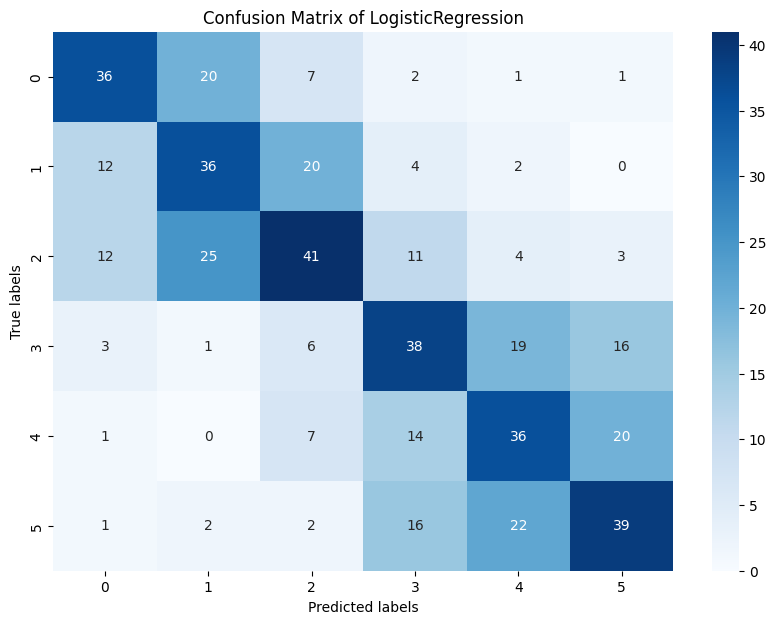

K-NearestNeighbors: {'Accuracy': 0.4708333333333333, 'Precision': 0.5006144583777281, 'Recall': 0.48489323746854135, 'F1-score': 0.4716041906654633}


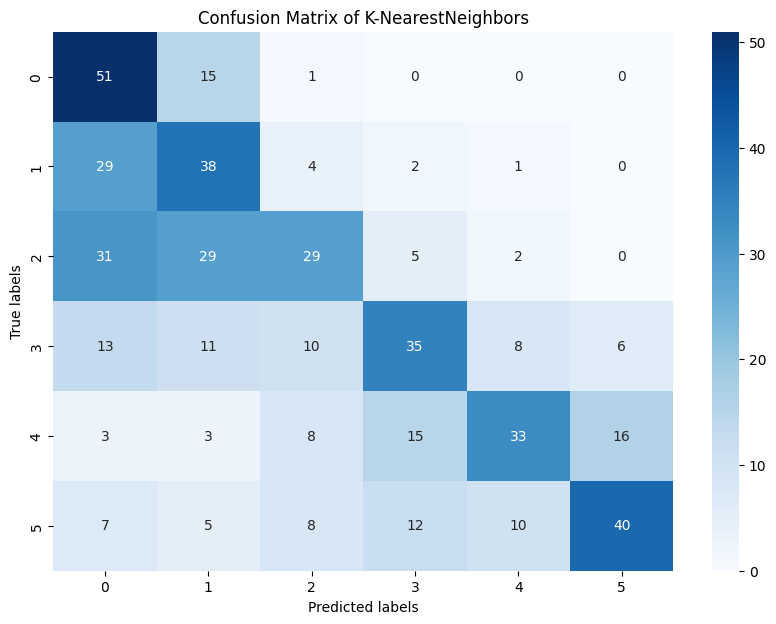

DecisionTree: {'Accuracy': 0.33958333333333335, 'Precision': 0.3448793792707339, 'Recall': 0.3456113742521478, 'F1-score': 0.3449198998531304}


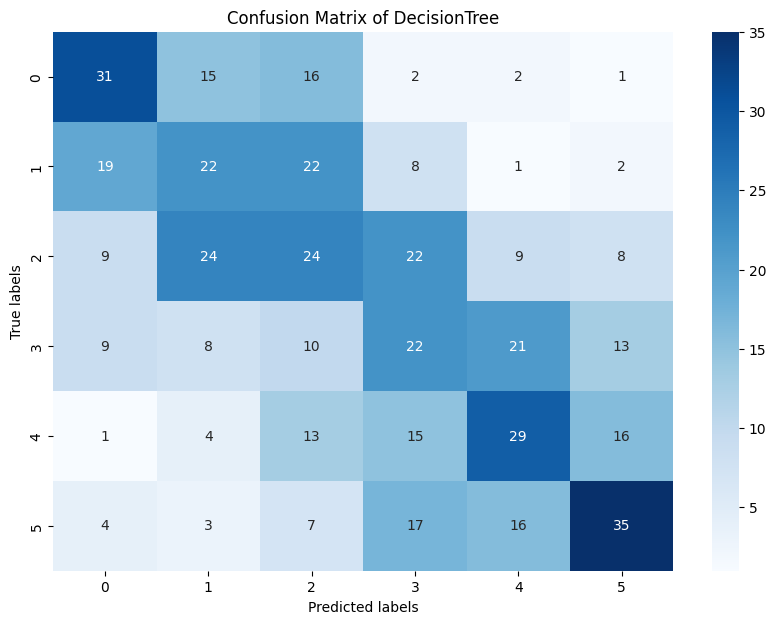

RandomForest: {'Accuracy': 0.5, 'Precision': 0.5005724385977959, 'Recall': 0.5053642153320445, 'F1-score': 0.49991208038970397}


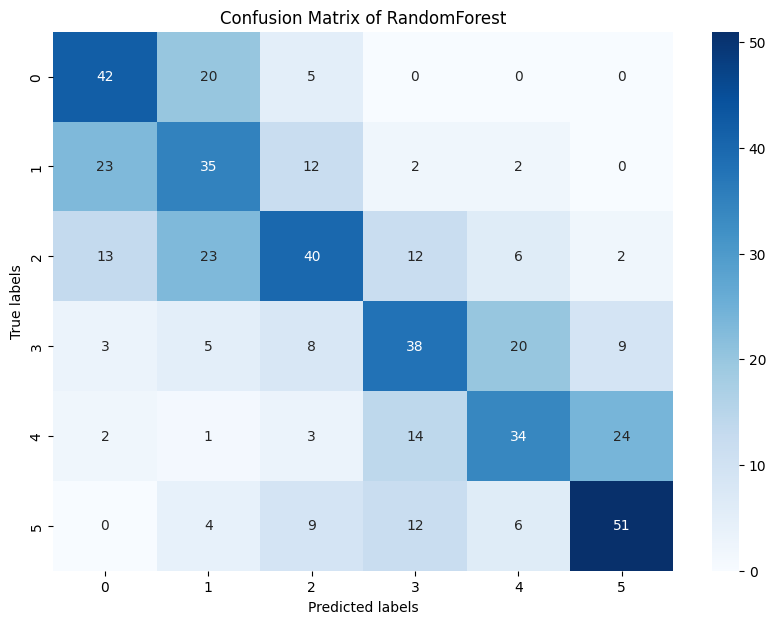

RandomForest(improved): {'Accuracy': 0.5333333333333333, 'Precision': 0.5322362615803621, 'Recall': 0.5364620773190116, 'F1-score': 0.5317055056606814}


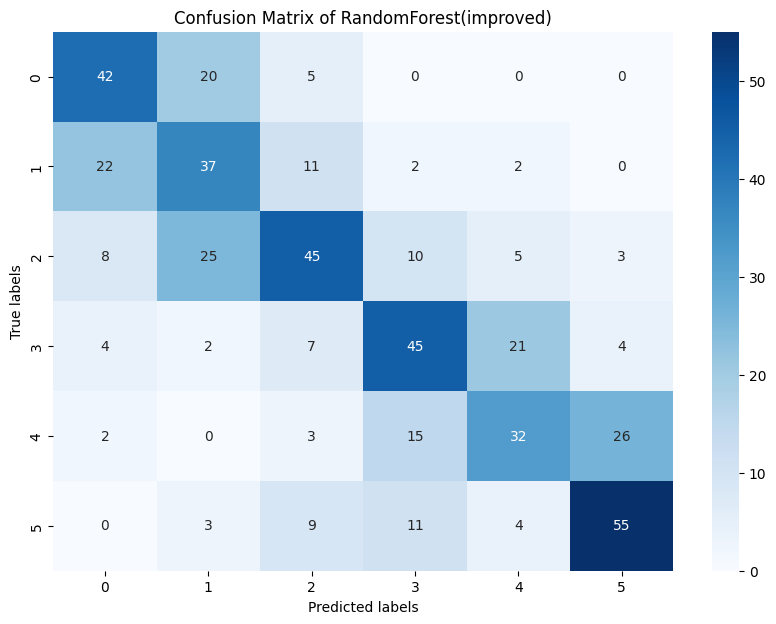

ExtraTree: {'Accuracy': 0.5166666666666667, 'Precision': 0.5153031611683951, 'Recall': 0.5235121661200248, 'F1-score': 0.516077536834105}


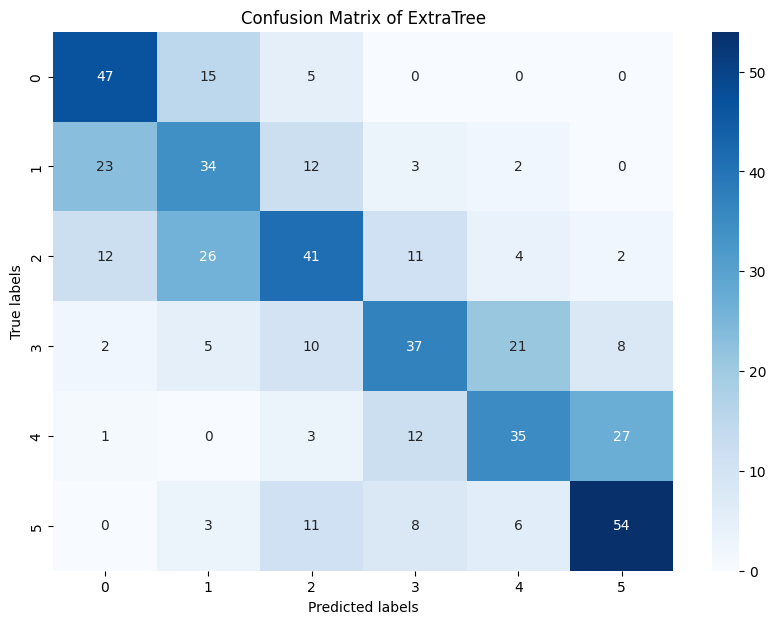

ExtraTree(improved): {'Accuracy': 0.5354166666666667, 'Precision': 0.5352401370468575, 'Recall': 0.541431520116852, 'F1-score': 0.5346473762199568}


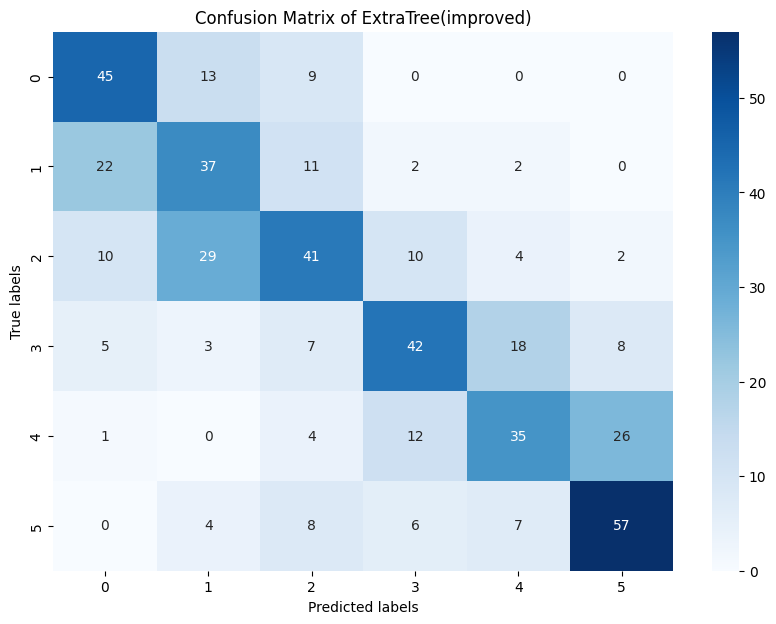

SupportVectorMachine: {'Accuracy': 0.5979166666666667, 'Precision': 0.597814860430141, 'Recall': 0.5987990775302564, 'F1-score': 0.5964555967596973}


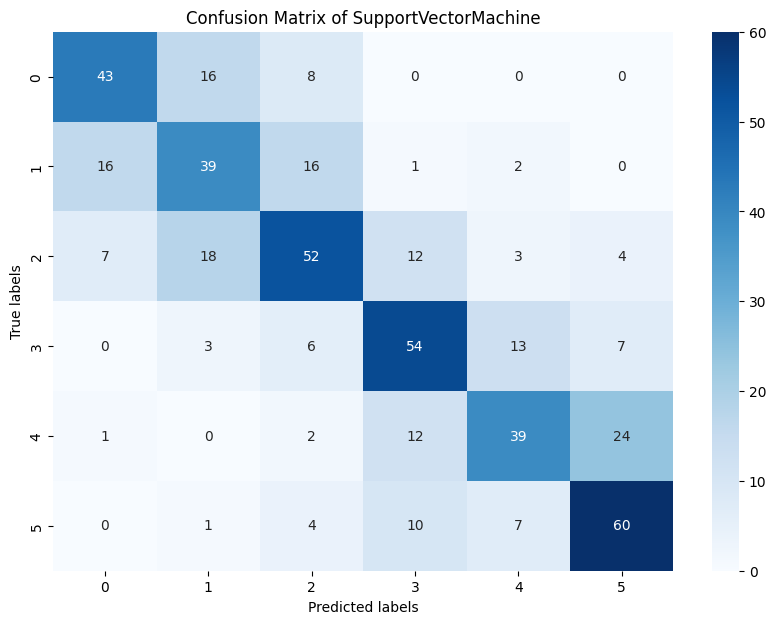

XGBoost: {'Accuracy': 0.5208333333333334, 'Precision': 0.5203233494538839, 'Recall': 0.5247852250831405, 'F1-score': 0.5215833851826458}


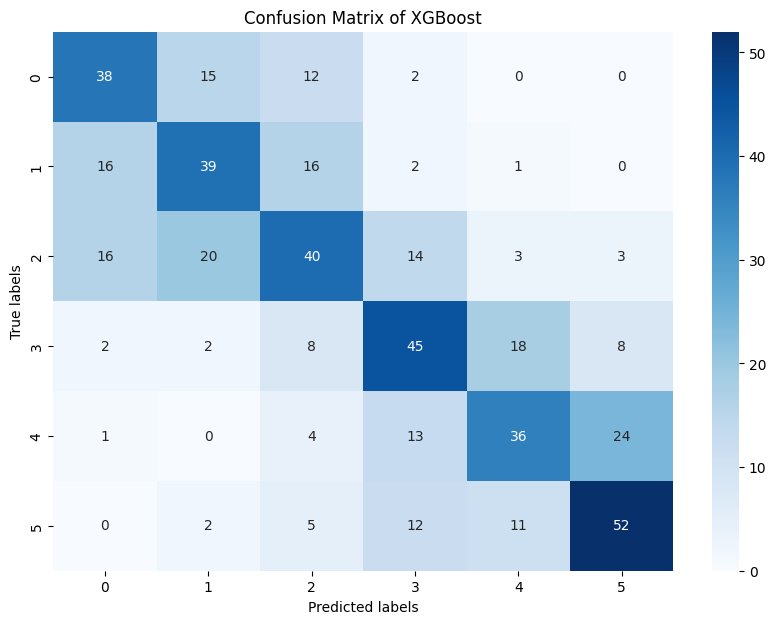

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4320, number of used features: 768
[LightGBM] [Info] Start training from score -1.756285
[LightGBM] [Info] Start training from score -1.790372
[LightGBM] [Info] Start training from score -1.821360
[LightGBM] [Info] Start training from score -1.807155
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.784839
LightGBM: {'Accuracy': 0.5541666666666667, 'Precision': 0.5555160256820321, 'Recall': 0.5578297627858951, 'F1-score': 0.5543827418125609}


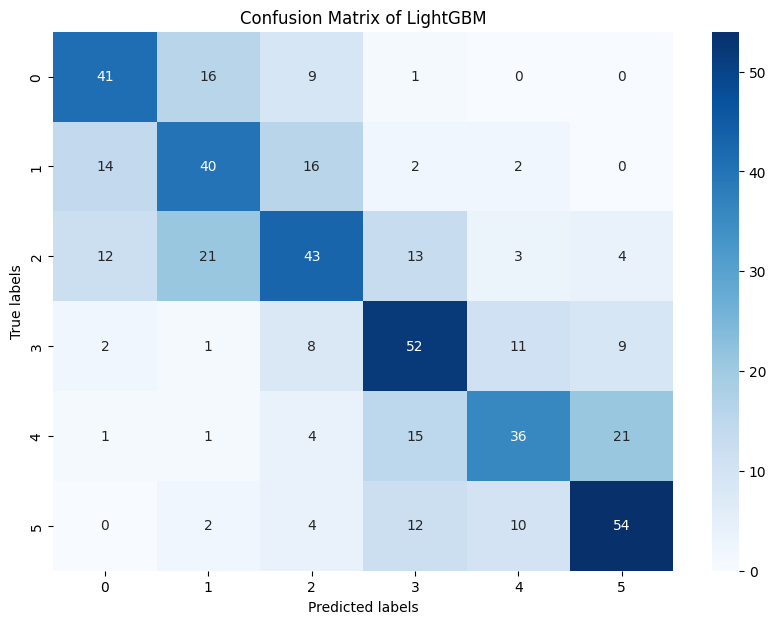

CatBoost: {'Accuracy': 0.5645833333333333, 'Precision': 0.5665918603118555, 'Recall': 0.566096197264002, 'F1-score': 0.5640813006231629}


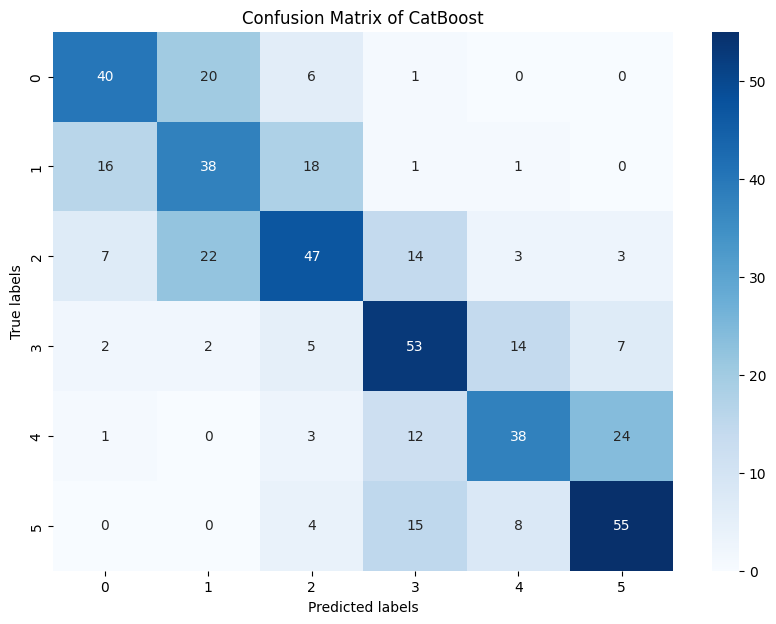

MLP: {'Accuracy': 0.5375, 'Precision': 0.5380801737874766, 'Recall': 0.5409035418646807, 'F1-score': 0.5390640258436851}


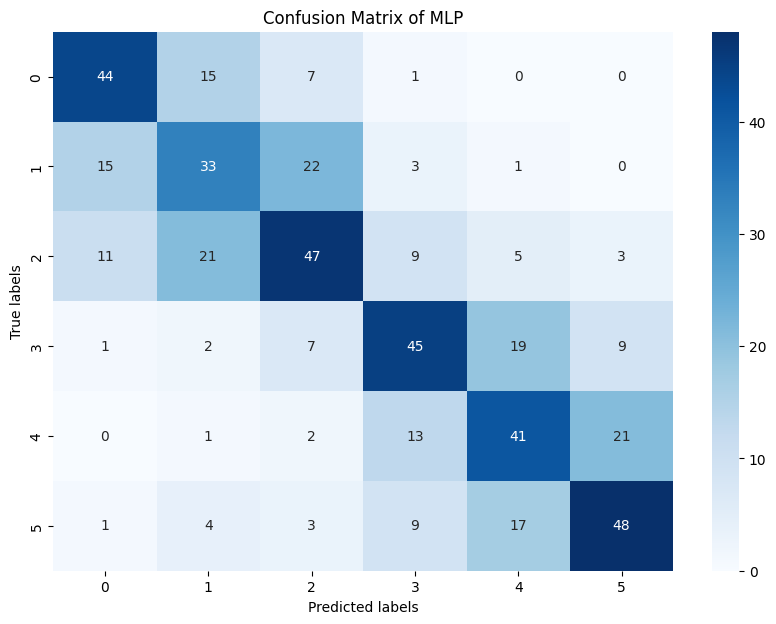

                        Accuracy  Precision    Recall  F1-score
LogisticRegression      0.470833   0.474282  0.474310  0.473425
K-NearestNeighbors      0.470833   0.500614  0.484893  0.471604
DecisionTree            0.339583   0.344879  0.345611  0.344920
RandomForest            0.500000   0.500572  0.505364  0.499912
RandomForest(improved)  0.533333   0.532236  0.536462  0.531706
ExtraTree               0.516667   0.515303  0.523512  0.516078
ExtraTree(improved)     0.535417   0.535240  0.541432  0.534647
SupportVectorMachine    0.597917   0.597815  0.598799  0.596456
XGBoost                 0.520833   0.520323  0.524785  0.521583
LightGBM                0.554167   0.555516  0.557830  0.554383
CatBoost                0.564583   0.566592  0.566096  0.564081
MLP                     0.537500   0.538080  0.540904  0.539064


In [9]:
#train + evaluate each model
for name, model in models.items():
    try:
        model.fit(train_features_scaled, train_labels)
        results = evaluation(model, val_features_scaled, val_labels)
        model_comparison.loc[name] = results
        print(f"{name}: {results}")
        # create confusion matrix
        val_predictions = model.predict(val_features_scaled)
        cm_model = confusion_matrix(val_labels, val_predictions)

        # plot cm
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm_model, annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title(f'Confusion Matrix of {name}')
        plt.show()
    except Exception as e:
        print(f"Error evaluating {name}: {e}")

print(model_comparison)

In [10]:
whole_labels = [difficulty_mapping[label] for label in list(training_data['difficulty'])]
whole_encodings = bert_feature(list(training_data['sentence']))
whole_features_scaled = scaler.transform(whole_encodings)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 4800/4800 [14:36<00:00,  5.48it/s]


In [11]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "K-NearestNeighbors": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42),
    "RandomForest(improved)": RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=300, random_state=42),
    "ExtraTree": ExtraTreesClassifier(random_state=42),
    "ExtraTree(improved)": ExtraTreesClassifier(min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42),
    "SupportVectorMachine": SVC(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "MLP": MLPClassifier()
}

import joblib
#retrain each model with the full dataset and test prediction by each model
for name, model in models.items():
    try:
        #retrain each model with the full dataset
        model.fit(whole_features_scaled, whole_labels)
        print(f"{name}: retrain successful.")
        #test prediction by each model
        predictions = model.predict(test_features_scaled)
        submission = pd.DataFrame()
        submission['id'] = test_data['id']
        submission['difficulty'] = pd.Series(predictions).map({0:'A1', 1:'A2', 2:'B1', 3:'B2', 4:'C1', 5:'C2'})

        filename = f'submission_{name}.csv'
        submission.to_csv(filename, index=False)
        print(f"{name}: Prediction and file save successful.")

        pklname = f'{name}.pkl'
        joblib.dump(model, pklname)
    except Exception as e:
        print(f"Error evaluating {name}: {e}")

LogisticRegression: retrain successful.
LogisticRegression: Prediction and file save successful.
K-NearestNeighbors: retrain successful.
K-NearestNeighbors: Prediction and file save successful.
DecisionTree: retrain successful.
DecisionTree: Prediction and file save successful.
RandomForest: retrain successful.
RandomForest: Prediction and file save successful.
RandomForest(improved): retrain successful.
RandomForest(improved): Prediction and file save successful.
ExtraTree: retrain successful.
ExtraTree: Prediction and file save successful.
ExtraTree(improved): retrain successful.
ExtraTree(improved): Prediction and file save successful.
SupportVectorMachine: retrain successful.
SupportVectorMachine: Prediction and file save successful.
XGBoost: retrain successful.
XGBoost: Prediction and file save successful.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

In [12]:
label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}

for name, model in models.items():
    try:
        model.fit(train_features_scaled, train_labels)

        val_predictions = model.predict(val_features_scaled)

        # Convert val_labels list to a numpy array for consistent operations
        val_labels_array = np.array(val_labels)

        # Apply mapping to convert numeric labels to their corresponding categories
        true_labels_mapped = pd.Series(val_labels_array).map(label_mapping)
        pred_labels_mapped = pd.Series(val_predictions).map(label_mapping)

        # Compute errors where predictions do not match labels
        error_mask = val_labels_array != val_predictions

        print(f"Error examples for {name}:")
        # Iterate over the indices of the errors, showing up to 5 examples
        error_indices = np.where(error_mask)[0][:5]
        for idx in error_indices:
            print(f"Index: {idx}, True Label: {true_labels_mapped.iloc[idx]}, Predicted Label: {pred_labels_mapped.iloc[idx]}")

    except Exception as e:
        print(f"Error evaluating {name}: {e}")

Error examples for LogisticRegression:
Index: 2, True Label: A2, Predicted Label: B2
Index: 5, True Label: A1, Predicted Label: A2
Index: 7, True Label: B2, Predicted Label: C2
Index: 9, True Label: C2, Predicted Label: C1
Index: 11, True Label: B1, Predicted Label: C1
Error examples for K-NearestNeighbors:
Index: 0, True Label: C2, Predicted Label: B2
Index: 1, True Label: A1, Predicted Label: A2
Index: 6, True Label: C1, Predicted Label: C2
Index: 7, True Label: B2, Predicted Label: C1
Index: 9, True Label: C2, Predicted Label: C1
Error examples for DecisionTree:
Index: 2, True Label: A2, Predicted Label: B1
Index: 3, True Label: B1, Predicted Label: C2
Index: 4, True Label: A2, Predicted Label: A1
Index: 6, True Label: C1, Predicted Label: C2
Index: 7, True Label: B2, Predicted Label: C1
Error examples for RandomForest:
Index: 2, True Label: A2, Predicted Label: B2
Index: 4, True Label: A2, Predicted Label: A1
Index: 6, True Label: C1, Predicted Label: C2
Index: 7, True Label: B2, P